In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from scipy import stats
from scipy.stats import pearsonr, levene
import os
import myvariant

In [2]:
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
tag = "26_nov"

In [3]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

In [4]:
def get_gene_names(to_query):
    mv = myvariant.MyVariantInfo()

    gene_names = {}
    a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

    for i in range(len(a)):
        q = a[i]["query"]
        try:
            gene = a[i]["cadd"]["gene"]["genename"]
        except:
            try:
                gene = a[i]["dbsnp"]["gene"]["symbol"]
            except:
                try:
                    gene = a[i]["wellderly"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"]["genename"]
                    except:
                        try:
                            gene = a[i]["snpeff"]["ann"][0]["genename"]
                        except:
                            if q == "rs111763415":
                                gene = "SUFU"
                            elif q == "rs568365616":
                                gene = "MOG"
                            else:
                                gene = "not found"
        if q in gene_names:
            gene_names[q].append(gene)
        else:
            gene_names[q] = [gene]
    
    for q in gene_names:
        gene_names[q] = list(set(gene_names[q]))
        gene_names[q] = ", ".join(gene_names[q])
    
    return gene_names

# GWAS of ADP without MPV

In [5]:
files_noMPV = glob("%s/%s/chr_*_ADP_noMPV.*.glm.linear" % (export_folder,tag))

In [6]:
dfs = []
for f in tqdm(sorted(files_noMPV)):
    df = pd.read_csv(f,sep="\t")
    df["pheno"] = f.split(".")[-3] + "_no_MPV"
    dfs.append(df)
df = pd.concat(dfs,axis=0)
df["MBP"] = df["POS"] // int(1e6)
df = df.sort_values("P")

100%|██████████| 22/22 [00:16<00:00,  1.36it/s]


In [7]:
# GRK5
df.loc[df.ID == "rs10886430"]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,pheno,MBP
444166,10,121010256,rs10886430,G,A,G,ADD,21133,0.098495,0.014358,6.86011,7.071060e-12,ADP_pred_no_MPV,121


In [8]:
recap_noMPV = df.loc[(df.P < 5e-8) & (df.ID != ".")].groupby(["#CHROM","MBP"]).first()

In [9]:
recap_noMPV

POS           ID REF ALT A1 TEST  OBS_CT      BETA  \
#CHROM MBP                                                             
1      111  111596290   rs11102203   G   A  G  ADD   22866  0.053424   
       156  156869714   rs12041331   A   G  A  ADD   23255 -0.156699   
       157  157048876    rs2068299   C   T  C  ADD   23074 -0.153915   
       161  161188893       rs3557   G   T  G  ADD   23103 -0.094755   
       198  198974904   rs10919615   T   C  C  ADD   23484  0.066718   
       199  199010721    rs1434282   T   C  C  ADD   22062  0.069823   
       247  247712303   rs41315846   C   T  C  ADD   21379 -0.077013   
2      241  241510903   rs78909033   A   G  A  ADD   23509 -0.118918   
3      56    56849749    rs1354034   C   T  T  ADD   23464  0.123577   
       124  124340093   rs13067286   A   G  A  ADD   23490  0.057190   
5      122  122088890     rs922140   G   A  A  ADD   23246 -0.092269   
6      29    29904202   rs28749106   C   T  C  ADD   20967 -0.054820   
       31    31326148   rs35173808   A   C  A  ADD   23277 -0.120737   
8      9      9030160    rs3748136   A   G  A  ADD   23409  0.073526   
9      99    99234329   rs55665228   T   C  T  ADD   22347 -0.087655   
       113  113312231   rs61751937   C   G  C  ADD   23599  0.196083   
10     121  121010256   rs10886430   G   A  G  ADD   21133  0.098495   
12     122  122216910   rs11553699   G   A  G  ADD   19816  0.214061   
14     70    70653758   rs61978213   A   G  A  ADD   23547  0.144780   
16     9      9052473    rs4076904   A   C  A  ADD   22635  0.070478   
       81    81876294   rs62045702   T   C  T  ADD   23236  0.129817   
17     3      3819002   rs11078475   C   T  T  ADD   23083 -0.059453   
18     20    20715656  rs113232639   A   G  A  ADD   20852  0.053555   
19     55    55538980    rs1654425   C   T  T  ADD   23519 -0.119607   

                  SE    T_STAT             P            pheno  
#CHROM MBP                                                     
1      111  0.009297   5.74641  9.231450e-09  ADP_pred_no_MPV  
       156  0.015909  -9.84978  7.614880e-23  ADP_pred_no_MPV  
       157  0.023224  -6.62729  3.494580e-11  ADP_pred_no_MPV  
       161  0.016083  -5.89178  3.873610e-09  ADP_pred_no_MPV  
       198  0.010524   6.33963  2.345150e-10  ADP_pred_no_MPV  
       199  0.010519   6.63780  3.258090e-11  ADP_pred_no_MPV  
       247  0.009419  -8.17666  3.079420e-16  ADP_pred_no_MPV  
2      241  0.013186  -9.01856  2.047930e-19  ADP_pred_no_MPV  
3      56   0.009184  13.45640  4.012170e-41  ADP_pred_no_MPV  
       124  0.009001   6.35346  2.143900e-10  ADP_pred_no_MPV  
5      122  0.009241  -9.98487  1.979380e-23  ADP_pred_no_MPV  
6      29   0.009942  -5.51395  3.550060e-08  ADP_pred_no_MPV  
       31   0.015703  -7.68864  1.545800e-14  ADP_pred_no_MPV  
8      9    0.011029   6.66680  2.672550e-11  ADP_pred_no_MPV  
9      99   0.012113  -7.23636  4.757950e-13  ADP_pred_no_MPV  
       113  0.026589   7.37472  1.701270e-13  ADP_pred_no_MPV  
10     121  0.014358   6.86011  7.071060e-12  ADP_pred_no_MPV  
12     122  0.014740  14.52240  1.535460e-47  ADP_pred_no_MPV  
14     70   0.022361   6.47460  9.693700e-11  ADP_pred_no_MPV  
16     9    0.011690   6.02907  1.674590e-09  ADP_pred_no_MPV  
       81   0.013012   9.97633  2.156660e-23  ADP_pred_no_MPV  
17     3    0.009107  -6.52802  6.802790e-11  ADP_pred_no_MPV  
18     20   0.009520   5.62564  1.871960e-08  ADP_pred_no_MPV  
19     55   0.012004  -9.96377  2.442910e-23  ADP_pred_no_MPV

In [33]:
gw_ = df.copy()

In [11]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

100%|██████████| 22/22 [07:00<00:00, 19.10s/it]

93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']


In [34]:
gw_["IN_UKBB"] = gw_.ID.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

0.9126884883048515


In [35]:
gw_["G_POS"] = 0
offset = 0
for chrom in tqdm(range(1,23)):
    chrom_cond = gw_["#CHROM"] == chrom
    gw_.loc[chrom_cond,"G_POS"] = gw_.loc[chrom_cond,"POS"] + offset
    offset = int(1e6) + gw_.loc[chrom_cond,"G_POS"].max()

100%|██████████| 22/22 [00:06<00:00,  3.29it/s]


# GWAS of ADP with MPV covariate

In [ ]:
files_MPV = glob("%s/%s/chr_*_ADP_MPV.*.glm.linear" % (export_folder,tag))

In [ ]:
dfs = []
for f in tqdm(sorted(files_MPV)):
    df = pd.read_csv(f,sep="\t")
    df["pheno"] = f.split(".")[-3] + "_no_MPV"
    dfs.append(df)
df = pd.concat(dfs,axis=0)
df["MBP"] = df["POS"] // int(1e6)
df = df.sort_values("P")

In [ ]:
recap_MPV = df.loc[(df.P < 5e-8) & (df.ID != ".")].groupby(["#CHROM","MBP"]).first()

In [ ]:
recap_noMPV

In [ ]:
no_mpv_hits = recap_noMPV.ID.tolist()
mpv_hits = recap_MPV.ID.tolist()

In [ ]:
get_gene_names(no_mpv_hits)

In [ ]:
get_gene_names(mpv_hits)

# Causal analysis

In [36]:
pheno_cols = ["ADP_pred"]

In [37]:
phenotypes = pd.read_csv("%s/%s/hippo_ADP.csv" % (export_folder,tag), sep="\t")
cov = pd.read_csv("%s/%s/covariates_PCs_noMPV.csv" % (export_folder,tag), sep="\t")

In [38]:
phenotypes.head()

,FID,IID,ADP_pred
0,110005883349,110005883349,0.377075
1,110005883350,110005883350,2.347780
2,110003971725,110003971725,-0.666306
3,110003971720,110003971720,0.442402
4,110003971745,110003971745,1.018989


In [39]:
cov.head()

,FID,IID,AGE,interval_cohort,SEX,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,110005883349,110005883349,20.8,M08,1,-0.001934,-0.000559,-0.003877,-0.002396,0.004759,0.009209,-0.007094,0.005961,-0.002420
1,110005883350,110005883350,28.5,M10,1,0.005680,-0.003885,0.006915,-0.005141,-0.007857,-0.005673,0.002623,0.004581,-0.002501
2,110003971725,110003971725,56.4,F14,2,0.006316,-0.008532,-0.002536,0.005346,0.003799,-0.004373,-0.001642,-0.002100,0.001090
3,110003971720,110003971720,61.5,F14,2,0.000077,0.005795,-0.001567,0.003430,-0.008434,0.002795,0.001299,-0.007729,0.002039
4,110003971745,110003971745,34.4,M10,1,-0.006810,-0.003914,0.003027,-0.006723,-0.000179,-0.005756,-0.000391,-0.005852,0.002590


In [40]:
phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = [c for c in list(cov.columns) if c not in ["ID","IID","FID"]]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

In [41]:
X.head()

,AGE,interval_cohort,SEX,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,ADP_pred
ID,,,,,,,,,,,,,
110005883349_110005883349,20.8,M08,1,-0.001934,-0.000559,-0.003877,-0.002396,0.004759,0.009209,-0.007094,0.005961,-0.002420,0.377075
110005883350_110005883350,28.5,M10,1,0.005680,-0.003885,0.006915,-0.005141,-0.007857,-0.005673,0.002623,0.004581,-0.002501,2.347780
110003971725_110003971725,56.4,F14,2,0.006316,-0.008532,-0.002536,0.005346,0.003799,-0.004373,-0.001642,-0.002100,0.001090,-0.666306
110003971720_110003971720,61.5,F14,2,0.000077,0.005795,-0.001567,0.003430,-0.008434,0.002795,0.001299,-0.007729,0.002039,0.442402
110003971745_110003971745,34.4,M10,1,-0.006810,-0.003914,0.003027,-0.006723,-0.000179,-0.005756,-0.000391,-0.005852,0.002590,1.018989


In [42]:
from sklearn.metrics import log_loss
from scipy.stats import chi2
import math

In [43]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

def calcLogLikelihood(guess, true, n):
    error = true-guess
    sigma = np.std(true)
    #f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
    #    np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    
    f = -(n/2)*np.log(2*math.pi*(sigma**2))
    f -= (np.dot(error.T,error))/(2*sigma*sigma)
    
    return f

def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression()
    lm1.fit(X[model],Y)
    lm2 = LinearRegression()
    lm2.fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    # Log_loss is minus log-likelihood
    LL_1 = calcLogLikelihood(fit_1,Y,Y.shape[0])
    LL_2 = calcLogLikelihood(fit_2,Y,Y.shape[0])
    Delta_LL = LL_2 - LL_1 # Delta_LL is positive
    LR = 2*Delta_LL
    p_val = chi2.sf(LR, 1)
    #print(p_val)
    
    #print("LL : %.2f" % p_val)
    
    # Checked that it yields the same result !
    
    #residuals = Y-fit_1
    #lm3 = LinearRegression()
    #lm3.fit(X[augmented_model],residuals)
    #fit3 = lm3.predict(X[augmented_model])
    #p_val2 = pearsonr(fit3,residuals)[1]
    #
    #print("Pearson : %.2f" % p_val2)
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    #p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

In [44]:
gw_ = gw_.rename(columns={"ID":"SNP","#CHROM":"CHR","POS":"BP"})

In [45]:
gw_["pheno"] = "ADP_pred"

In [46]:
# POS devrait être la position globale sur le génome

## Run

In [49]:
covar_cols = ['AGE',
 #'interval_cohort',
 'SEX',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9']

In [50]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in ["ADP_pred"]:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.G_POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d / %d" % (region,hits.region.nunique()))
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --mac 50"
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = list(set([c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]))
        df = df[ID_cols].T
        df = df.loc[:, ~df.columns.duplicated()]
        var_cols = list(set(list(df.columns)))
        
        for var in var_cols:
            is_null = df[var].isnull()
            df.loc[is_null,var] = df.loc[~is_null,var].mean()
        
        G_X = pd.merge(df,X.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        G = G.loc[:,~G.columns.duplicated()]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[h.sort_values("P").SNP.tolist()]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            print("%d vars not in model" % len(vars_not_in_model()))
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                print("Nothing to add, keep %s" % (model))
                break
            else:
                to_add = addition_p_values.sort_values().index[0]
                print("Adding %s" % to_add)
                model.append(to_add)
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,reduced_model,model,Y[c])
                if removal_p_values.max() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P","BETA"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
ADP_pred
Region 0 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


21 vars not in model
Adding rs3557
20 vars not in model
Nothing to add, keep ['rs12041331', 'rs3557']
Done causal variant extraction. Kept 2 out of 22
Hit : 
        CHR         BP         SNP             P      BETA
439520    1  156869714  rs12041331  7.614880e-23 -0.156699
456034    1  161188893      rs3557  3.873610e-09 -0.094755
Region 1 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


120 vars not in model
Nothing to add, keep ['rs35173808']
Done causal variant extraction. Kept 1 out of 121
Hit : 
        CHR        BP         SNP             P      BETA
144037    6  31326148  rs35173808  1.545800e-14 -0.120737
Region 2 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


39 vars not in model
Nothing to add, keep ['rs1354034']
Done causal variant extraction. Kept 1 out of 40
Hit : 
        CHR        BP        SNP             P      BETA
209082    3  56849749  rs1354034  4.012170e-41  0.123577
Region 3 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


78 vars not in model
Nothing to add, keep ['rs11553699']
Done causal variant extraction. Kept 1 out of 79
Hit : 
        CHR         BP         SNP             P      BETA
432837   12  122216910  rs11553699  1.535460e-47  0.214061
Region 4 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


18 vars not in model
Nothing to add, keep ['rs55665228']
Done causal variant extraction. Kept 1 out of 19
Hit : 
        CHR        BP         SNP             P      BETA
282331    9  99234329  rs55665228  4.757950e-13 -0.087655
Region 5 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20 vars not in model
Adding rs76445378
19 vars not in model
Nothing to add, keep ['rs13067286', 'rs76445378']
Done causal variant extraction. Kept 2 out of 21
Hit : 
        CHR         BP         SNP             P      BETA
436447    3  124340093  rs13067286  2.143900e-10  0.057190
436670    3  124366890  rs76445378  3.077260e-09 -0.217009
Region 6 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


118 vars not in model
Nothing to add, keep ['rs1654425']
Done causal variant extraction. Kept 1 out of 119
Hit : 
        CHR        BP        SNP             P      BETA
224957   19  55538980  rs1654425  2.442910e-23 -0.119607
Region 7 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9 vars not in model
Nothing to add, keep ['rs78909033']
Done causal variant extraction. Kept 1 out of 10
Hit : 
        CHR         BP         SNP             P      BETA
829203    2  241510903  rs78909033  2.047930e-19 -0.118918
Region 8 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 vars not in model
Nothing to add, keep ['rs61751937']
Done causal variant extraction. Kept 1 out of 2
Hit : 
        CHR         BP         SNP             P      BETA
335591    9  113312231  rs61751937  1.701270e-13  0.196083
Region 9 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR         BP         SNP             P      BETA
444166   10  121010256  rs10886430  7.071060e-12  0.098495
Region 10 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 vars not in model
Nothing to add, keep ['rs3748136']
Done causal variant extraction. Kept 1 out of 2
Hit : 
       CHR       BP        SNP             P      BETA
61352    8  9030160  rs3748136  2.672550e-11  0.073526
Region 11 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3 vars not in model
Nothing to add, keep ['rs4076904']
Done causal variant extraction. Kept 1 out of 4
Hit : 
       CHR       BP        SNP             P      BETA
47461   16  9052473  rs4076904  1.674590e-09  0.070478
Region 12 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


557 vars not in model
Nothing to add, keep ['rs922140']
Done causal variant extraction. Kept 1 out of 558
Hit : 
        CHR         BP       SNP             P      BETA
436263    5  122088890  rs922140  1.979380e-23 -0.092269
Region 13 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8 vars not in model
Nothing to add, keep ['rs11078475']
Done causal variant extraction. Kept 1 out of 9
Hit : 
       CHR       BP         SNP             P      BETA
18199   17  3819002  rs11078475  6.802790e-11 -0.059453
Region 14 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 vars not in model
Nothing to add, keep ['rs41315846']
Done causal variant extraction. Kept 1 out of 3
Hit : 
        CHR         BP         SNP             P      BETA
772722    1  247712303  rs41315846  3.079420e-16 -0.077013
Region 15 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR         BP         SNP             P      BETA
378543    1  111596290  rs11102203  9.231450e-09  0.053424
Region 16 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


11 vars not in model
Nothing to add, keep ['rs1434282']
Done causal variant extraction. Kept 1 out of 12
Hit : 
        CHR         BP        SNP             P      BETA
589261    1  199010721  rs1434282  3.258090e-11  0.069823
Region 17 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR        BP         SNP             P     BETA
189930   14  70653758  rs61978213  9.693700e-11  0.14478
Region 18 / 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


72 vars not in model
Nothing to add, keep ['rs62045702']
Done causal variant extraction. Kept 1 out of 73
Hit : 
        CHR        BP         SNP             P      BETA
262531   16  81876294  rs62045702  2.156660e-23  0.129817


## Gather

In [51]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [52]:
gw_.head()

,CHR,BP,SNP,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,pheno,MBP,IN_UKBB,G_POS
432837,12,122216910,rs11553699,G,A,G,ADD,19816,0.214061,0.014740,14.5224,1.535460e-47,ADP_pred,122,True,2083589394
209082,3,56849749,rs1354034,C,T,T,ADD,23464,0.123577,0.009184,13.4564,4.012170e-41,ADP_pred,56,True,551276148
433291,12,122365583,rs7961894,T,C,T,ADD,23624,0.176793,0.014033,12.5986,2.812420e-36,ADP_pred,122,True,2083738067
433436,12,122399173,rs11615667,A,C,A,ADD,22042,0.172506,0.014541,11.8633,2.304010e-32,ADP_pred,122,True,2083771657
432670,12,122180206,rs201197641,G,GC,G,ADD,21174,0.192535,0.017716,10.8678,1.939520e-27,ADP_pred,122,False,2083552690


In [53]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw_.loc[gw_.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)

In [54]:
recap = pd.merge(recap,gw_.loc[(gw_.pheno == pheno_cols[0]) & (gw_.P < 5e-8),["SNP","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

## Export

In [55]:
pheno_cols

['ADP_pred']

In [56]:
snp_path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,"ADP_pred")

In [57]:
with open(snp_path,"w") as f:
    for snp in significant_SNPs[c]:
        f.write("%s\n" % snp)

In [58]:
significant_SNPs["ADP_pred"]

['rs12041331',
 'rs3557',
 'rs35173808',
 'rs1354034',
 'rs11553699',
 'rs55665228',
 'rs13067286',
 'rs76445378',
 'rs1654425',
 'rs78909033',
 'rs61751937',
 'rs10886430',
 'rs3748136',
 'rs4076904',
 'rs922140',
 'rs11078475',
 'rs41315846',
 'rs11102203',
 'rs1434282',
 'rs61978213',
 'rs62045702']

In [59]:
gene_names = get_gene_names(significant_SNPs["ADP_pred"])
gene_names_df = pd.DataFrame.from_dict(gene_names,orient="index").rename(columns={0:"GENE"})

querying 1-21...done.
Finished.
6 input query terms found dup hits:
	[('rs1654425', 3), ('rs61751937', 2), ('rs922140', 2), ('rs11078475', 2), ('rs41315846', 2), ('rs111
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [60]:
gene_names_df

,GENE
rs12041331,PEAR1
rs3557,FCER1G
rs35173808,HLA-B
rs1354034,ARHGEF3
rs11553699,TMEM120B
rs55665228,HABP4
rs13067286,KALRN
rs76445378,KALRN
rs1654425,GP6
rs78909033,RNPEPL1


In [61]:
good = gw_.loc[(gw_.pheno == "ADP_pred") & (gw_.SNP.isin(significant_SNPs["ADP_pred"]))]

## Load VEP output

In [35]:
VEP = pd.read_csv("/home/hv270/sysmex2pf/hippo_500kb_filtering.txt",sep="\t")
VEP = VEP.loc[VEP.Location.str[0].isin(["%d" % i for i in range(1,10)])]

In [40]:
to_export = pd.merge(good,VEP,right_on="#Uploaded_variation",left_on="SNP",how="left")
to_export.to_csv("/home/hv270/sysmex2pf/GWAS_table.csv")

In [ ]:
# A1 ?

In [82]:
genes_df = pd.merge(good,gene_names_df,left_on="SNP",right_index=True,how="left")
genes_df.to_csv("~/SNPs_for_score.csv")

In [83]:
genes_df

,CHR,BP,SNP,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,pheno,MBP,IN_UKBB,G_POS,GENE
209082,3,56849749,rs1354034,C,T,T,ADD,23464,0.175427,0.008449,20.76230,6.785670e-95,ADP_pred,56,True,551276148,ARHGEF3
432837,12,122216910,rs11553699,G,A,G,ADD,19816,0.228176,0.013603,16.77350,1.033340e-62,ADP_pred,122,True,2083589394,TMEM120B
436263,5,122088890,rs922140,G,A,A,ADD,23246,-0.095698,0.008541,-11.20460,4.593500e-29,ADP_pred,122,True,1007521547,LOC101927379-SNX2
93023,17,27852493,rs79610227,TGG,T,TGG,ADD,23582,-0.090029,0.008321,-10.81940,3.229580e-27,ADP_pred,27,True,2543279755,TAOK1
197803,20,57597970,rs463312,C,A,C,ADD,23593,-0.198768,0.019758,-10.06020,9.251700e-24,ADP_pred,57,True,2794351551,TUBB1
829203,2,241510903,rs78909033,A,G,A,ADD,23509,-0.120158,0.012194,-9.85363,7.321840e-23,ADP_pred,241,True,491751446,RNPEPL1
247304,10,65038030,rs9787438,C,G,C,ADD,23499,-0.074472,0.008406,-8.85898,8.635430e-19,ADP_pred,65,True,1753939729,JMJD1C
24797,12,6282429,rs1362214,G,A,G,ADD,21224,0.069846,0.008806,7.93130,2.275370e-15,ADP_pred,6,True,1967654913,VWF-CD9
143754,6,31321578,rs7762909,G,A,A,ADD,22456,-0.070378,0.009058,-7.76995,8.187610e-15,ADP_pred,31,True,1098590833,HLA-B
406993,7,106367636,rs67036916,A,G,A,ADD,23464,0.064049,0.008347,7.67333,1.741020e-14,ADP_pred,106,True,1345690297,CTB-111H14.1


# Compute score

In [62]:
causal_snps = [c[:-1] for c in open(snp_path,"r").readlines()]

In [63]:
first_pheno = pheno_cols[0]
betas = good[["SNP","BETA"]].rename(columns={"BETA":first_pheno})
betas = pd.merge(betas,gw_.loc[gw_.pheno == first_pheno,["SNP","A1"]],left_on="SNP",right_on="SNP",how="left")
betas = betas[["SNP","A1"] + pheno_cols]
betas.fillna(0,inplace=True)
assert betas.shape[0] == betas.SNP.nunique()

In [64]:
good_chroms = []
for c in good:
    good_chroms += good.CHR.unique().tolist()
good_chroms = list(set(good_chroms))
print(good_chroms)

[1, 2, 3, 5, 6, 8, 9, 10, 12, 14, 16, 17, 19]


In [65]:
if not os.path.exists("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag)):
    os.mkdir("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag))

In [66]:
for f in glob("%s/Genetic_score_Sysmex_traits/%s/good_score_chr*.sscore" % (export_folder,tag)):
    os.remove(f)

In [67]:
# Checked that BETA is to be multiplied with the number of A1

In [68]:
betas_path = "%s/Genetic_score_Sysmex_traits/betas.csv" % (export_folder)
betas.to_csv(betas_path,
            sep="\t",index=False)

n_splits = 16

all_causal_path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)

for chrom in good_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    #command += " --extract %s" % causal_snps_path
    command += " --keep %s" % EUR_path
    command += " --extract %s" % snp_path
    command += " --score %s header-read center" % betas_path
    if len(pheno_cols) > 1:
        command += " --score-col-nums 3-%d" % (2 + len(pheno_cols))
    else:
        command += " --score-col-nums 3"
    command += " --out %s/Genetic_score_Sysmex_traits/%s/good_score_chr%s" % (export_folder,tag,chrom)
    command += " --threads %d" % n_splits
    
    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=2:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 5
Submitting 6
Submitting 8
Submitting 9
Submitting 10
Submitting 12
Submitting 14
Submitting 16
Submitting 17
Submitting 19


In [51]:
"%s/Genetic_score_Sysmex_traits/%s/good_score_chr%s" % (export_folder,tag,chrom)

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/26_nov/good_score_chr19'

# Comparison with Dragana's

In [93]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [94]:
draganas_genes = ",".join([g for g in dgw.Gene.unique().tolist() if isinstance(g, str)]).split(",")

In [95]:
hippo_genes = ",".join(gene_names_df.GENE.unique().tolist()).split(",")

In [96]:
# Export lists of genes and SNPS
# SNPs are then passed to ensembl VEP tool to get ENSEMBL IDs

In [97]:
with open("/home/hv270/all_hippo_genes.txt","w") as f:
    for SNP in list(set(hippo_genes)):
        f.write("%s\n" % SNP)

In [98]:
with open("/home/hv270/all_draganas_genes.txt","w") as f:
    for SNP in list(set(draganas_genes)):
        f.write("%s\n" % SNP)

In [99]:
with open("/home/hv270/all_hippo_SNPs.txt","w") as f:
    for SNP in list(set(causal_snps)):
        f.write("%s\n" % SNP)

In [100]:
with open("/home/hv270/all_draganas_SNPs.txt","w") as f:
    for SNP in list(dgw.SNP.unique()):
        f.write("%s\n" % SNP)

In [101]:
dgw.head()

,Associated Blood Index,Novel vs Astle 2016,Locus ID,Associated Blood Index Class,Unique Variant ID,Gene,SNP,INFO SCORE,Chr (GRCh37),BP (GRCh37),...,"(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(UNIVAR) Standard Error of Estimator,(UNIVAR) -log10 P,(UNIVAR) Unadjusted R2,"(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(MULTI) Standard Error of Estimate,(MULTI) -log10 P,Most Serious VEP Consequence of Variant,VEP IMPACT of Most Serious Consequence,Ensembl Gene ID(s) for Most Serious Consequence
8,PLT#,True,3.0,Platelet,1:2166607_G_GT,SKI,rs34646035,0.993972,1,2166607,...,-0.025125,0.002100,32.257710,0.000316,-0.025898,0.002244,30.075942,intron_variant,MODIFIER,ENSG00000157933
9,PCT,True,3.0,Platelet,1:2166607_G_GT,SKI,rs34646035,0.993972,1,2166607,...,-0.022806,0.002115,26.382239,0.000260,-0.022753,0.002250,23.309318,intron_variant,MODIFIER,ENSG00000157933
10,PDW,False,4.0,Platelet,1:2234040_CAGG_C,SKI,rs141190925,0.998629,1,2234040,...,-0.031649,0.002791,29.068109,0.000294,-0.032328,0.002904,28.044832,intron_variant,MODIFIER,ENSG00000157933
14,PCT,False,6.0,Platelet,1:2978755_A_AG,AL008733.1,rs113565775,0.987314,1,2978755,...,0.029835,0.002699,27.682668,0.000276,0.018624,0.002942,9.609021,splice_region_variant,LOW,ENSG00000256761
16,PCT,False,8.0,Platelet,1:2996602_T_C,PRDM16,rs1569419,0.977773,1,2996602,...,0.041643,0.002518,60.729775,0.000622,0.039968,0.002746,47.262073,intron_variant,MODIFIER,ENSG00000142611


In [106]:
PLT_genes = ",".join([g for g in dgw.loc[dgw["Associated Blood Index"] == "PLT#"].SNP.unique().tolist() if isinstance(g, str)]).split(",")

In [107]:
with open("/home/hv270/all_PLT_SNPs.txt","w") as f:
    for SNP in list(PLT_genes):
        f.write("%s\n" % SNP)

In [108]:
PDW_genes = ",".join([g for g in dgw.loc[dgw["Associated Blood Index"] == "PDW"].SNP.unique().tolist() if isinstance(g, str)]).split(",")

In [109]:
with open("/home/hv270/all_PDW_SNPs.txt","w") as f:
    for SNP in list(PDW_genes):
        f.write("%s\n" % SNP)

# GWAS of Sysmex parameters

In [5]:
sysmex_files = glob("%s/%s/chr_*_sysmex*.glm.linear" % (export_folder, tag))

In [6]:
dfs = []
for f in sysmex_files:
    trait = f.split(".")[-3]
    chrom = int(f.split("/")[-1].split("_")[1])
    df = pd.read_csv(f,sep="\t")
    df["trait"] = trait
    dfs.append(df)
gw = pd.concat(dfs,axis=0)

In [6]:
gw["MBP"] = gw["POS"] // int(1e6)

In [7]:
offset = 0
gw["G_POS"] = 0
for CHR in range(1,23):
    cond = gw["#CHROM"] == CHR
    gw.loc[cond,"G_POS"] = offset + gw.loc[cond,"POS"]
    offset = gw.loc[cond,"G_POS"].max()

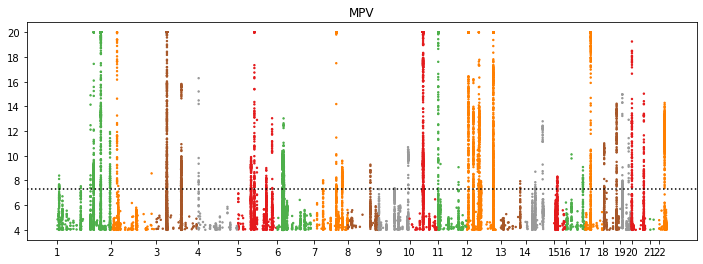

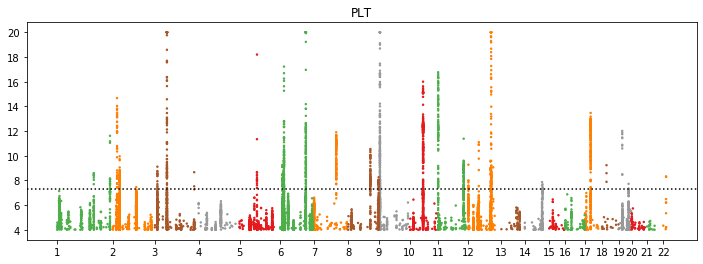

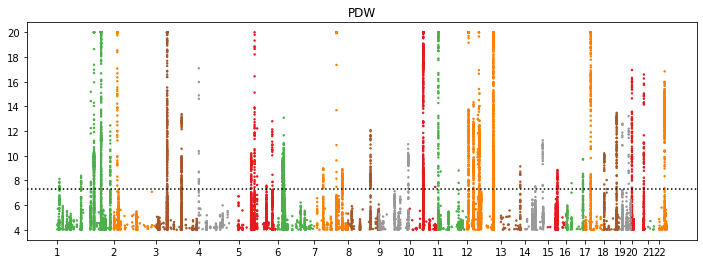

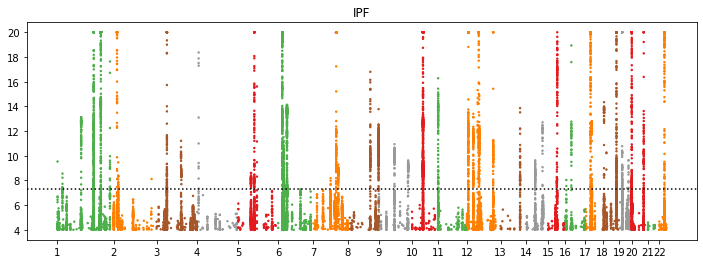

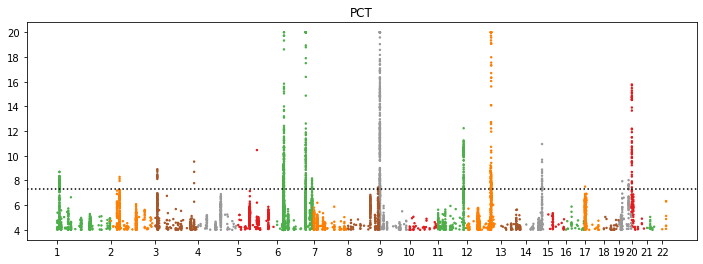

In [8]:
for t in gw.trait.unique().tolist():
    cond = gw.trait == t
    cond = cond & (gw.P < 1e-4)
    s = gw.loc[cond].copy()
    s.loc[s.P < 1e-20,"P"] = 1e-20
    plt.figure(figsize=(12,4))
    plt.scatter(s["G_POS"],-np.log10(s["P"]),c=s["#CHROM"] % 5,cmap="Set1",s=2)
    plt.axhline(-np.log10(5e-8),c="black",ls=":")
    plt.xticks([s.loc[s["#CHROM"] == c,"G_POS"].min() for c in range(1,23)],["%d" % c for c in range(1,23)])
    plt.title(t)

In [165]:
gw = gw.sort_values(["#CHROM","POS"])

In [166]:
recap_sysmex = gw.pivot_table(index=["#CHROM","MBP"],columns=["trait"],values=["P"],aggfunc="min")

In [167]:
recap_sysmex = recap_sysmex.loc[(recap_sysmex < 5e-8).sum(axis=1) > 0]

In [168]:
recap_sysmex_best = pd.DataFrame(recap_sysmex[["P"]].min(axis=1)).rename(columns={0:"P"})

In [169]:
recap_sysmex

P                                            \
trait                  IPF           MPV           PCT           PDW   
#CHROM MBP                                                             
1      2.0    2.905620e-10  1.410250e-05  4.037160e-06  1.976340e-06   
       10.0   1.314030e-05  4.013800e-09  5.807140e-04  7.465110e-09   
       12.0   7.714770e-04  5.064500e-04  1.932280e-09  2.900580e-04   
       25.0   2.774790e-09  1.922900e-07  1.867150e-04  1.162100e-06   
       111.0  1.565010e-06  2.948320e-08  1.724400e-04  4.192790e-09   
...                    ...           ...           ...           ...   
19     45.0   2.307360e-10  1.208540e-13  9.348540e-09  6.214710e-14   
20     1.0    1.095370e-32  5.589300e-20  1.686670e-16  1.120830e-17   
       57.0   4.333300e-73  9.350170e-16  3.166280e-04  2.627180e-17   
22     43.0   3.426530e-25  5.197300e-15  3.422030e-04  1.467050e-17   
       50.0   3.768470e-05  2.382480e-06  4.665440e-07  2.473510e-06   

                            
trait                  PLT  
#CHROM MBP                  
1      2.0    2.524020e-05  
       10.0   7.250980e-08  
       12.0   1.794320e-07  
       25.0   3.662420e-04  
       111.0  2.922960e-05  
...                    ...  
19     45.0   1.869900e-08  
20     1.0    4.733660e-06  
       57.0   2.285020e-05  
22     43.0   7.666590e-04  
       50.0   4.680880e-09  

[101 rows x 5 columns]

# GWAS of unadjusted features

In [6]:
unadj_files = glob("%s/%s/chr_*_unadjusted_no_covars*.glm.linear" % (export_folder, tag))

In [7]:
dfs = []
for f in tqdm(unadj_files):
    trait = f.split(".")[-3]
    chrom = int(f.split("/")[-1].split("_")[1])
    df = pd.read_csv(f,sep="\t")
    df = df.loc[df.P < 1e-3]
    df["trait"] = trait
    dfs.append(df)
gwu = pd.concat(dfs,axis=0)

100%|██████████| 330/330 [04:00<00:00,  1.37it/s]


In [8]:
gwu["MBP"] = gwu["POS"] // int(1e6)
gwu = gwu.sort_values(["#CHROM","POS"])

In [9]:
offset = 0
gwu["G_POS"] = 0
for CHR in range(1,23):
    cond = gwu["#CHROM"] == CHR
    gwu.loc[cond,"G_POS"] = offset + gwu.loc[cond,"POS"]
    offset = gwu.loc[cond,"G_POS"].max()

In [10]:
def make_recap(gw):
    recap = gw.loc[(gw.P < 1e-3) & (gw.ID != ".")]\
        .pivot_table(index=["ID"],columns=["trait"],values=["P","BETA"],aggfunc="min",fill_value=1e-3)
    recap = pd.merge(recap,gw.loc[gw.trait == gw.trait.iloc[0],["ID","#CHROM","MBP"]],
                     left_index=True,right_on="ID",how="left")
    recap["min_p"] = recap[[("P",t) for t in gw.trait.unique().tolist()]].min(axis=1)
    recap = recap.loc[recap.min_p < 5e-8].sort_values("min_p").groupby(["#CHROM","MBP"]).first()
    return recap

In [11]:
recap_unadj = make_recap(gwu)

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [13]:
recap_unadj

(BETA, iqr_0_unadjusted)  (BETA, iqr_1_unadjusted)  \
#CHROM MBP                                                         
1.0    2.0                   -0.059619                  0.001000   
       25.0                  -0.041783                 -0.030872   
       113.0                 -0.055848                  0.001000   
       171.0                 -0.204040                 -0.080737   
       172.0                 -0.273434                  0.001000   
...                                ...                       ...   
19.0   39.0                  -0.083196                  0.001000   
       45.0                   0.071173                  0.059617   
20.0   1.0                   -0.070629                  0.001000   
       57.0                   0.294774                 -0.212729   
22.0   43.0                  -0.102626                 -0.065334   

              (BETA, lower_0_unadjusted)  (BETA, lower_1_unadjusted)  \
#CHROM MBP                                                             
1.0    2.0                     -0.064671                    0.001000   
       25.0                    -0.043112                    0.033155   
       113.0                   -0.041744                    0.001000   
       171.0                   -0.068625                    0.038819   
       172.0                    0.001000                    0.001000   
...                                  ...                         ...   
19.0   39.0                    -0.058478                    0.001000   
       45.0                     0.001000                    0.001000   
20.0   1.0                     -0.097433                    0.001000   
       57.0                    -0.314774                   -0.169574   
22.0   43.0                    -0.030818                    0.035712   

              (BETA, median_0_unadjusted)  (BETA, median_1_unadjusted)  \
#CHROM MBP                                                               
1.0    2.0                      -0.069590                     0.001000   
       25.0                     -0.046271                     0.001000   
       113.0                    -0.051648                     0.001000   
       171.0                    -0.129584                     0.001000   
       172.0                    -0.163865                     0.001000   
...                                   ...                          ...   
19.0   39.0                     -0.077249                     0.001000   
       45.0                      0.051508                     0.001000   
20.0   1.0                      -0.086367                     0.001000   
       57.0                     -0.205879                    -0.222546   
22.0   43.0                     -0.060451                     0.001000   

              (BETA, ratio_lower_unadjusted)  (BETA, ratio_std_unadjusted)  \
#CHROM MBP                                                                   
1.0    2.0                          0.060583                      0.058573   
       25.0                         0.032501                      0.035909   
       113.0                        0.044757                      0.063868   
       171.0                        0.156183                      0.191576   
       172.0                        0.217228                      0.290721   
...                                      ...                           ...   
19.0   39.0                         0.092709                      0.089828   
       45.0                        -0.049092                     -0.039054   
20.0   1.0                          0.043299                      0.090826   
       57.0                         0.001000                     -0.699220   
22.0   43.0                         0.062518                      0.085364   

              (BETA, ratio_upper_unadjusted)  (BETA, std_0_unadjusted)  ...  \
#CHROM MBP                                                              ...   
1.0    2.0                          0.073849            

In [12]:
chmbp_unadj = [(chrom, int(p)) for chrom, p in recap_unadj.index.tolist()]

In [16]:
features_SNPs = [recap_unadj.loc[(chrom,mbp),"ID"] for chrom, mbp in chmbp_unadj]

In [17]:
features_genes = get_gene_names(features_SNPs)

querying 1-91...done.
Finished.
39 input query terms found dup hits:
	[('rs1569419', 3), ('rs12037133', 3), ('rs78057682', 2), ('rs56043070', 2), ('rs645744', 2), ('rs711
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [21]:
gwu.loc[(gwu.MBP == 156) & (gwu["#CHROM"] == 1)].sort_values("P")

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,trait,MBP,G_POS
439516,1,156869047,rs12566888,T,G,T,ADD,24091,0.085077,0.015925,5.34250,9.250360e-08,lower_1_unadjusted,156,156869047
439533,1,156874874,rs398053431,T,TGG,T,ADD,23770,0.084531,0.016555,5.10610,3.314190e-07,lower_1_unadjusted,156,156874874
439520,1,156869714,rs12041331,A,G,A,ADD,23796,0.082346,0.016216,5.07821,3.838910e-07,lower_1_unadjusted,156,156869714
439512,1,156867990,rs2182760,A,G,A,ADD,23946,0.081374,0.016804,4.84255,1.289840e-06,lower_1_unadjusted,156,156867990
439520,1,156869714,rs12041331,A,G,A,ADD,23796,-0.075638,0.016212,-4.66552,3.095100e-06,iqr_1_unadjusted,156,156869714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437764,1,156245918,rs144991356,C,CT,C,ADD,21359,-0.033783,0.010251,-3.29562,9.836410e-04,upper_0_unadjusted,156,156245918
437971,1,156312331,rs12022194,A,T,A,ADD,24027,-0.033157,0.010067,-3.29374,9.900580e-04,median_0_unadjusted,156,156312331
437868,1,156281020,rs12132794,C,G,C,ADD,24121,-0.033024,0.010029,-3.29294,9.928890e-04,median_0_unadjusted,156,156281020
439666,1,156907031,rs4570419,T,C,T,ADD,24133,-0.040967,0.012441,-3.29278,9.934640e-04,lower_1_unadjusted,156,156907031


In [18]:
features_genes

{'rs1569419': ['PRDM16', 'PRDM16', 'PRDM16'],
 'rs4603124': ['LDLRAP1'],
 'rs10857963': ['ST7L'],
 'rs12037133': ['DNM3', 'DNM3', 'DNM3'],
 'rs78057682': ['DNM3', 'DNM3'],
 'rs17625587': ['LINC01221'],
 'rs1434282': ['LINC01221'],
 'rs1172130': ['TMCC2'],
 'rs1911546': ['KCNK2-KCTD3'],
 'rs56043070': ['GCSAML', 'GCSAML'],
 'rs1339847': ['TRIM58'],
 'rs645744': ['EHD3', 'EHD3'],
 'rs711244': ['AC007382.1', 'STRN'],
 'rs11673921': ['MFSD6'],
 'rs12617860': ['CATIP-SLC11A1'],
 'rs7574937': ['ANKZF1'],
 'rs7605551': ['DOCK10'],
 'rs78909033': ['RNPEPL1'],
 'rs1354034': ['ARHGEF3'],
 'rs1530455': ['PDIA5', 'PDIA5', 'PDIA5'],
 'rs34605102': ['KALRN', 'KALRN'],
 'rs11305804': ['ZMAT3', 'ZMAT3', 'ZMAT3'],
 'rs11731274': ['KIAA0232-TBC1D14', 'KIAA0232-TBC1D14'],
 'rs56224111': ['CLPTM1L'],
 'rs71606661': ['NDUFAF2'],
 'rs34592828': ['IQGAP2'],
 'rs2227831': ['F2R'],
 'rs114694170': ['MEF2C'],
 'rs6595407': ['LOC101927379-SNX2'],
 'rs2073644': ['SLC22A5'],
 'rs10076782': ['RNF145'],
 'rs2326836'

In [38]:
recap_sysmex = make_recap(gw)

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [40]:
recap_unadj

(BETA, iqr_0_unadjusted)  (BETA, iqr_1_unadjusted)  \
#CHROM MBP                                                       
1      2                   -0.059619                  0.001000   
       10                   0.073722                  0.058041   
       12                   0.001000                 -0.043809   
       25                  -0.041783                 -0.030872   
       35                   0.001000                 -0.060780   
...                              ...                       ...   
20     1                   -0.070629                  0.001000   
       19                   0.001000                  0.001000   
       57                   0.294774                 -0.212729   
22     38                   0.001000                  0.001000   
       43                  -0.102626                 -0.065334   

            (BETA, lower_0_unadjusted)  (BETA, lower_1_unadjusted)  \
#CHROM MBP                                                           
1      2                     -0.064671                    0.001000   
       10                     0.072529                    0.001000   
       12                     0.001000                    0.064325   
       25                    -0.043112                    0.033155   
       35                     0.035360                    0.001000   
...                                ...                         ...   
20     1                     -0.097433                    0.001000   
       19                     0.001000                   -0.051658   
       57                    -0.314774                   -0.169574   
22     38                    -0.133595                    0.001000   
       43                    -0.030818                    0.035712   

            (BETA, median_0_unadjusted)  (BETA, median_1_unadjusted)  \
#CHROM MBP                                                             
1      2                      -0.069590                     0.001000   
       10                      0.094973                     0.001000   
       12                      0.001000                     0.059438   
       25                     -0.046271                     0.001000   
       35                      0.001000                     0.001000   
...                                 ...                          ...   
20     1                      -0.086367                     0.001000   
       19                      0.001000                    -0.062626   
       57                     -0.205879                    -0.222546   
22     38                      0.001000                     0.001000   
       43                     -0.060451                     0.001000   

            (BETA, ratio_lower_unadjusted)  (BETA, ratio_std_unadjusted)  \
#CHROM MBP                                                                 
1      2                          0.060583                      0.058573   
       10                        -0.093331                      0.001000   
       12                         0.001000                      0.001000   
       25                         0.032501                      0.035909   
       35                         0.001000                      0.001000   
...                                    ...                           ...   
20     1                          0.043299                      0.090826   
       19                         0.001000                      0.001000   
       57                         0.001000                     -0.699220   
22     38                         0.001000                      0.001000   
       43                         0.062518                      0.085364   

            (BETA, ratio_upper_unadjusted)  (BETA, std_0_unadjusted)  ...  \
#CHROM MBP                                                            ...   
1      2                          0.073849                 -0.058573  ...   
       10                        -0.070209                  0.055568  ...   
       1

In [41]:
recap_sysmex

(BETA, IPF)  (BETA, MPV)  (BETA, PCT)  (BETA, PDW)  (BETA, PLT)  \
#CHROM MBP                                                                      
1      2.0      -0.069076    -0.047635    -0.050543    -0.052177     0.001000   
       10.0      0.066276     0.089398     0.001000     0.087875    -0.068387   
       12.0      0.001000     0.001000    -0.057634     0.001000    -0.049182   
       25.0     -0.055722    -0.048829     0.001000    -0.045615     0.001000   
       111.0     0.046924     0.057005     0.001000     0.061026     0.001000   
...                   ...          ...          ...          ...          ...   
19     45.0      0.061168     0.071578     0.001000     0.072483    -0.044142   
20     1.0      -0.122538    -0.091764    -0.082006    -0.085481    -0.044147   
       57.0      0.385585     0.001000    -0.070531     0.001000     0.001000   
22     43.0      0.094880     0.067579     0.001000     0.072668     0.001000   
       50.0      0.001000     0.001000     0.089081     0.001000     0.103800   

                  (P, IPF)      (P, MPV)      (P, PCT)      (P, PDW)  \
#CHROM MBP                                                             
1      2.0    2.905620e-10  1.410250e-05  4.037160e-06  1.976340e-06   
       10.0   1.314030e-05  4.013800e-09  1.000000e-03  7.465110e-09   
       12.0   1.000000e-03  1.000000e-03  1.932280e-09  1.000000e-03   
       25.0   2.774790e-09  1.922900e-07  1.000000e-03  1.162100e-06   
       111.0  6.238170e-06  4.120200e-08  1.000000e-03  4.192790e-09   
...                    ...           ...           ...           ...   
19     45.0   2.307360e-10  1.208540e-13  1.000000e-03  6.214710e-14   
20     1.0    1.095370e-32  4.935310e-19  1.690780e-15  1.002510e-16   
       57.0   4.333300e-73  1.000000e-03  9.815360e-04  1.000000e-03   
22     43.0   3.426530e-25  1.531270e-13  1.000000e-03  1.976440e-15   
       50.0   1.000000e-03  1.000000e-03  4.983590e-07  1.000000e-03   

                  (P, PLT)           ID         min_p  
#CHROM MBP                                             
1      2.0    1.000000e-03    rs1569419  2.905620e-10  
       10.0   7.024120e-06  rs572251659  4.013800e-09  
       12.0   3.086760e-07   rs11121846  1.932280e-09  
       25.0   1.000000e-03    rs4603124  2.774790e-09  
       111.0  1.000000e-03   rs68029231  4.192790e-09  
...                    ...          ...           ...  
19     45.0   4.958020e-06   rs11667430  6.214710e-14  
20     1.0    1.839450e-05   rs13042885  1.095370e-32  
       57.0   1.000000e-03     rs463312  4.333300e-73  
22     43.0   1.000000e-03   rs35321753  3.426530e-25  
       50.0   4.680880e-09   rs55955211  4.680880e-09  

[101 rows x 12 columns]

In [77]:
chmbp_sysmex = [(chrom, int(p)) for chrom, p in recap_sysmex.index.tolist()]
chmbp_unadj = [(chrom, int(p)) for chrom, p in recap_unadj.index.tolist()]

In [85]:
supplementary_SNPs = [recap_unadj.loc[(chrom,mbp),"ID"] for chrom, mbp in chmbp_unadj if (chrom,mbp) not in chmbp_sysmex]
lost_SNPs = [recap_sysmex.loc[(chrom,int(mbp)),"ID"] for chrom, mbp in chmbp_sysmex if (chrom,mbp) not in chmbp_unadj]
missing_chrbp = ["%s_%s" % c for c in chmbp_unadj if c not in chmbp_sysmex]

In [84]:
sup_genes = get_gene_names(supplementary_SNPs)
lost_genes = get_gene_names(lost_SNPs)

querying 1-68...done.
Finished.
30 input query terms found dup hits:
	[('rs1764390', 3), ('rs8942', 2), ('rs12036046', 3), ('rs6545465', 2), ('rs2044476', 2), ('rs5625967
3 input query terms found no hit:
	['rs568365616', 'rs112643470', 'rs143412439']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-25...done.
Finished.
16 input query terms found dup hits:
	[('rs61801999', 2), ('rs149290349', 2), ('rs10575146', 7), ('rs511515', 2), ('rs5881560', 9), ('rs75
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# Look into Dragana's GWAS

In [63]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [105]:
dgw["MBP"] = dgw["BP (GRCh37)"].astype(int) // int(1e6)
dgw["#CHROM"] = dgw["Chr (GRCh37)"]
dgw["chmbp"] = dgw["#CHROM"].astype(str) + "_" + dgw["MBP"].astype(str)
dgw["chmbp_1"] = dgw["#CHROM"].astype(str) + "_" + (dgw["MBP"]-1).astype(str)
dgw["chmbp_2"] = dgw["#CHROM"].astype(str) + "_" + (dgw["MBP"]+1).astype(str)

In [117]:
new_chmbp = [c for c in missing_chrbp if c not in dgw.loc[dgw.chmbp.isin(missing_chrbp)].chmbp.tolist()]
new_chmbp = [c for c in new_chmbp if c not in dgw.loc[dgw.chmbp.isin(missing_chrbp)].chmbp_1.tolist()]
new_chmbp = [c for c in new_chmbp if c not in dgw.loc[dgw.chmbp.isin(missing_chrbp)].chmbp_2.tolist()]

In [118]:
new_genes = get_gene_names([recap_unadj.loc[tuple([int(f) for f in c.split("_")]),"ID"] for c in new_chmbp])

querying 1-11...done.
Finished.
4 input query terms found dup hits:
	[('rs12036046', 3), ('rs56259671', 2), ('rs2516811', 2), ('rs41317034', 2)]
1 input query terms found no hit:
	['rs143412439']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [119]:
new_genes

{'rs12036046': ['KCNK2', 'KCNK2', 'KCNK2'],
 'rs56259671': ['ARHGEF3', 'ARHGEF3'],
 'rs11918767': ['HPS3'],
 'rs56859579': ['SLC36A1'],
 'rs56167897': ['C6orf203'],
 'rs12191772': ['Y_RNA'],
 'rs2516811': ['KIF25', 'KIF25'],
 'rs16868276': ['NCALD'],
 'rs41317034': ['HPS1', 'HPS1'],
 'rs302653': ['RAB38'],
 'rs143412439': ['not found']}

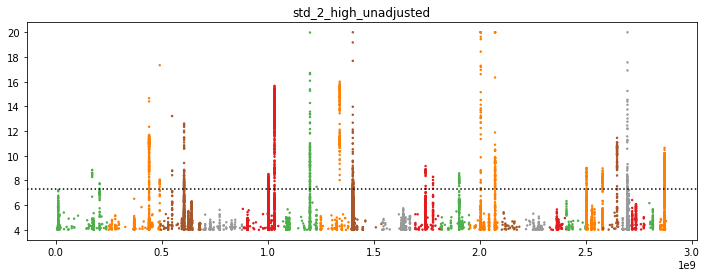

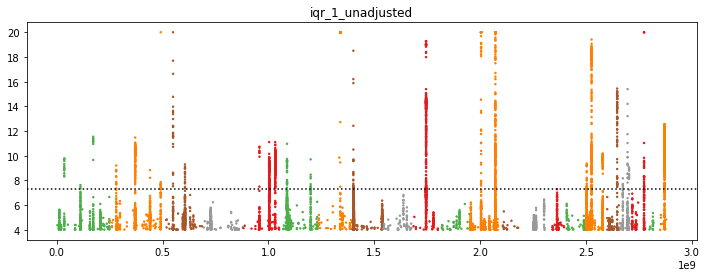

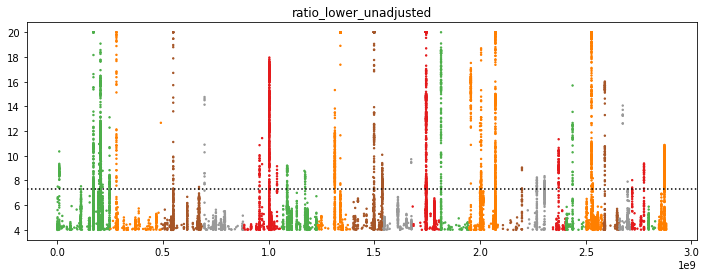

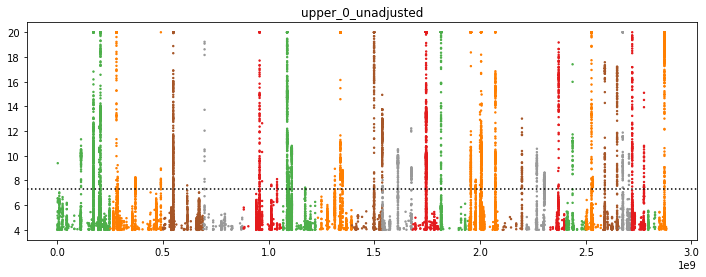

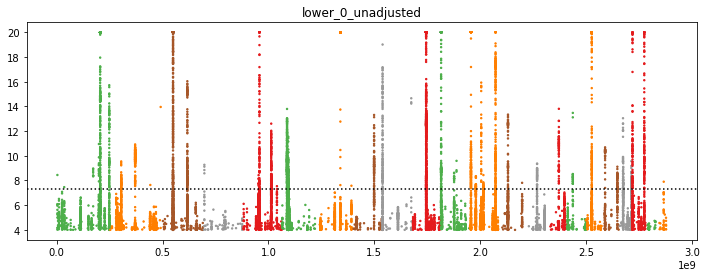

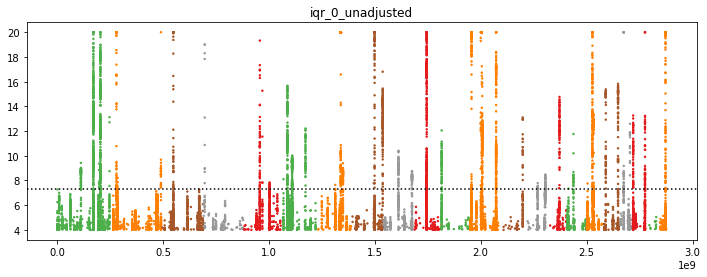

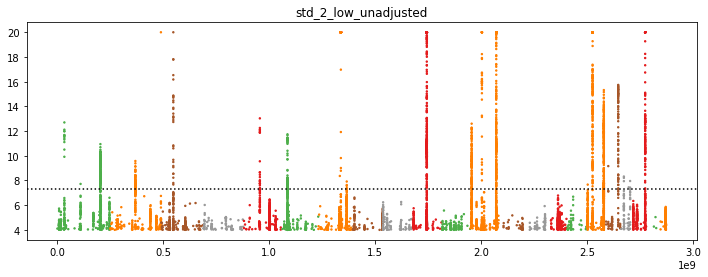

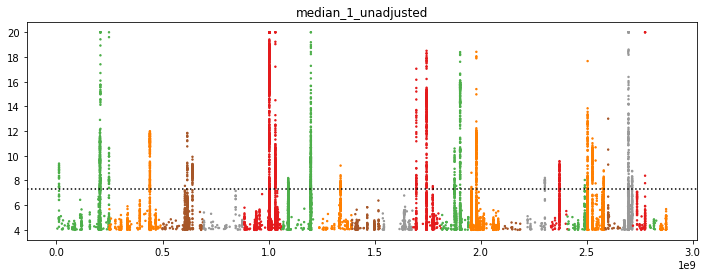

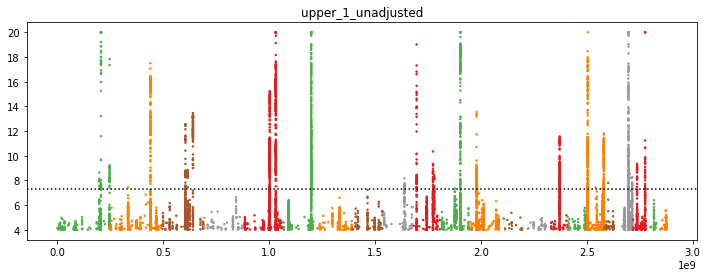

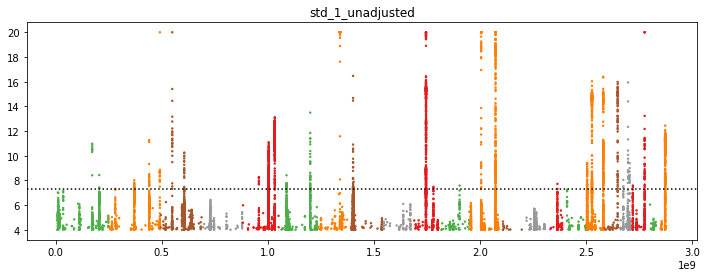

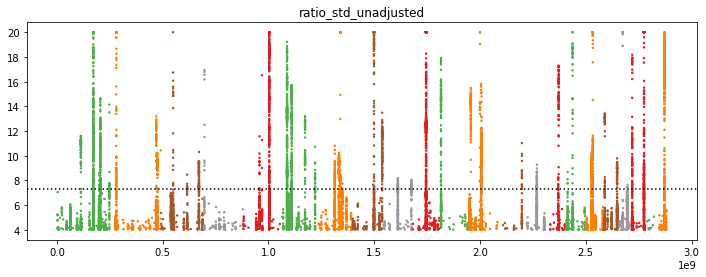

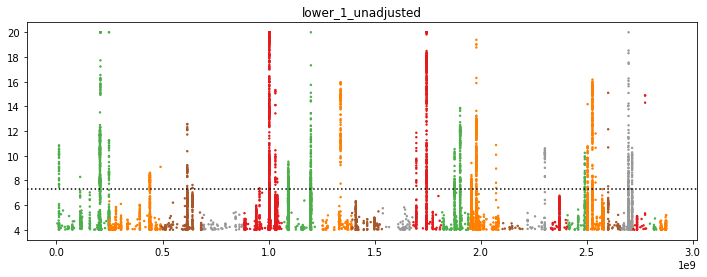

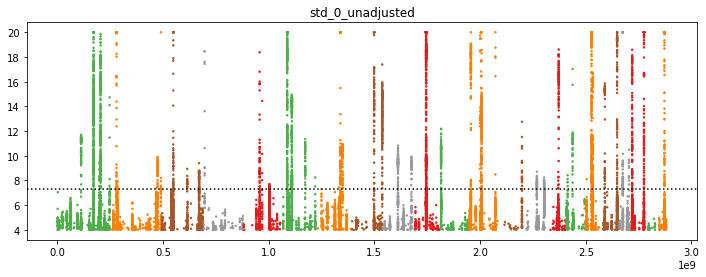

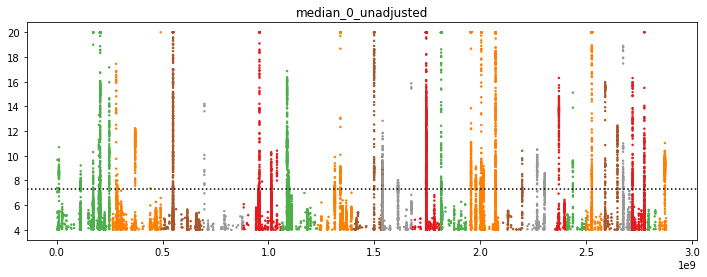

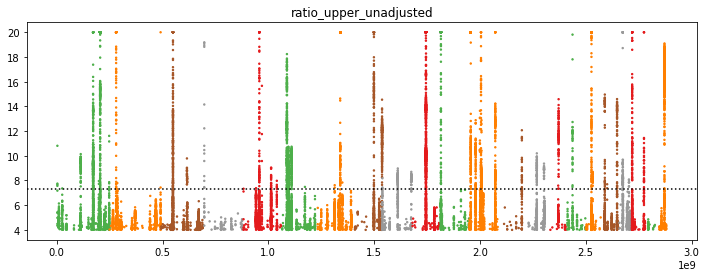

In [180]:
for t in gwu.trait.unique().tolist():
    cond = gwu.trait == t
    cond = cond & (gwu.P < 1e-4)
    s = gwu.loc[cond].copy()
    s.loc[s.P < 1e-20,"P"] = 1e-20
    plt.figure(figsize=(12,4))
    plt.scatter(s["G_POS"],-np.log10(s["P"]),c=s["#CHROM"] % 5,cmap="Set1",s=2)
    plt.axhline(-np.log10(5e-8),c="black",ls=":")
    plt.title(t)

# Compare the two

In [181]:
comp = pd.merge(recap_sysmex_best, recap_unadj_best,left_index=True,right_index=True,how="outer",suffixes=("_sys","_unadj"))

In [182]:
comp["log_P_sys"] = -np.log10(comp["P_sys"])

In [183]:
comp["log_P_unadj"] = -np.log10(comp["P_unadj"])

In [184]:
comp.loc[comp.log_P_sys.isnull(),"log_P_sys"] = 0
comp.loc[comp.log_P_unadj.isnull(),"log_P_unadj"] = 0

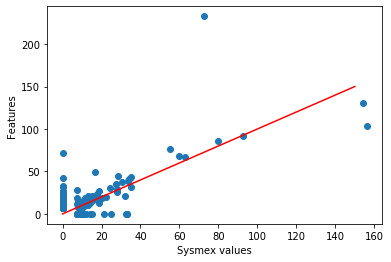

In [185]:
plt.scatter(comp.log_P_sys,comp.log_P_unadj)
plt.xlabel("Sysmex values")
plt.ylabel("Features")
plt.plot([0,150],[0,150],c="red")

In [188]:
comp.loc[comp.log_P_sys == 0]

P_sys       P_unadj  log_P_sys  log_P_unadj
#CHROM MBP                                               
1      35.0     NaN  1.996040e-13        0.0    12.699831
       198.0    NaN  4.967280e-14        0.0    13.303881
       199.0    NaN  3.134570e-13        0.0    12.503822
       204.0    NaN  3.926940e-08        0.0     7.405946
       207.0    NaN  5.092690e-25        0.0    24.293053
...             ...           ...        ...          ...
19     37.0     NaN  4.706240e-25        0.0    24.327326
       38.0     NaN  3.499800e-72        0.0    71.455957
       55.0     NaN  2.317670e-11        0.0    10.634948
20     19.0     NaN  4.418680e-10        0.0     9.354707
22     38.0     NaN  1.254540e-08        0.0     7.901515

[69 rows x 4 columns]

# w/covariates

In [137]:
covar_files = glob("%s/%s/chr_*_unadjusted_with_covars*.glm.linear" % (export_folder, tag))

In [138]:
dfs = []
for f in covar_files:
    trait = f.split(".")[-3]
    chrom = int(f.split("/")[-1].split("_")[1])
    df = pd.read_csv(f,sep="\t")
    df["trait"] = trait
    dfs.append(df)
gwc = pd.concat(dfs,axis=0)

/home/hv270/platelets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

In [96]:
gwc["MBP"] = gwc["POS"] // int(1e6)
gwc = gwc.sort_values(["#CHROM","POS"])

In [105]:
recap_cov = gwc.pivot_table(index=["#CHROM","MBP"],columns=["trait"],values=["P"],aggfunc="min",fill_value=1)

In [106]:
recap_cov = recap_cov.loc[(recap_cov < 5e-8).sum(axis=1) > 0]

In [117]:
recap_cov_best = pd.DataFrame(recap_cov.min(axis=1)).rename(columns={0:"P_cov"})

In [119]:
comp = pd.merge(comp, recap_cov_best, left_index=True,right_index=True,how="outer")
comp["log_P_cov"] = -np.log10(comp["P_cov"])
comp.loc[comp["log_P_cov"].isnull(),"log_P_cov"] = 0

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [131]:
log_P_thresh = -np.log10(5e-8)

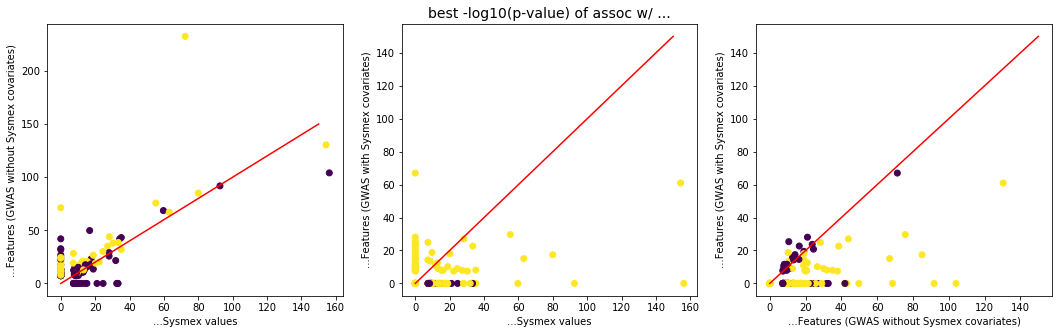

In [136]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
plt.scatter(comp.log_P_sys,comp.log_P_unadj,c=comp.log_P_cov >= log_P_thresh)
plt.xlabel("...Sysmex values")
plt.ylabel("...Features (GWAS without Sysmex covariates)")
plt.plot([0,150],[0,150],c="red")

ax = fig.add_subplot(132)
plt.title("best -log10(p-value) of assoc w/ ...",fontsize=14)
plt.scatter(comp.log_P_sys,comp.log_P_cov,c=comp.log_P_unadj >= log_P_thresh)
plt.xlabel("...Sysmex values")
plt.ylabel("...Features (GWAS with Sysmex covariates)")
plt.plot([0,150],[0,150],c="red")

ax = fig.add_subplot(133)
plt.scatter(comp.log_P_unadj,comp.log_P_cov,c=comp.log_P_sys >= log_P_thresh)
plt.xlabel("...Features (GWAS without Sysmex covariates)")
plt.ylabel("...Features (GWAS with Sysmex covariates)")
plt.plot([0,150],[0,150],c="red")

# Manhattan plot

In [6]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)

100%|██████████| 1/1 [00:11<00:00, 11.26s/it]


In [7]:
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]

In [8]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

100%|██████████| 22/22 [01:23<00:00,  3.80s/it]


93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.9246514910887594


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Select significant SNPs

## Prepare

In [9]:
cov = pd.read_csv("%s/%s/covars.csv" % (export_folder, tag), sep="\t")
phenotypes = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder, tag), sep="\t")

phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PLT","MPV","IPF","PCT","PDW","SEX","age_covar","cohort_covar"]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

## Utils

In [10]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

In [11]:
def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression().fit(X[model],Y)
    lm2 = LinearRegression().fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

## Run

In [12]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in pheno_cols:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d" % region)
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
        df = df[ID_cols].T
        var_cols = df.columns
        
        for var in var_cols:
            df.loc[df[var].isnull(),var] = df.loc[~df[var].isnull(),var].mean()
        
        G_X = pd.merge(df,X.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[[G.columns[i] for i in np.argsort(univariable_p_values)]]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                #print("Nothing to add, keep %s" % (model))
                break
            else:
                #print("Adding %s" % s)
                model.append(addition_p_values.sort_values().index[0])
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,model,reduced_model,Y[c])
                if removal_p_values.min() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
CCA
Region 0
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 10
Hit : 
         CHR         BP       SNP             P
6692618   12  111973358  rs597808  3.100000e-12
Region 1
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 14
Hit : 
         CHR       BP         SNP             P
5429659   10  3102379  rs11251684  3.900000e-09
5429877   10  3138009   rs2388595  1.200000e-10
Region 2
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 76
Hit : 
         CHR         BP        SNP             P
4897307    8  106581528  rs6993770  1.300000e-33
Region 3
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 611
Hit : 
         CHR         BP        SNP             P
3182100    5  122100398  rs6595407  6.400000e-40
3182995    5  122326008   rs425573  4.400000e-37
Region 4
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 24
Hit : 
         CHR         BP         SNP             P
1867766    3  124453114  rs11916134  1.300000e-09
Region 5
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 27
Hit : 
        CHR         BP         SNP             P
556208    1  207288392  rs17020993  4.300000e-19
Region 6
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 23
Hit : 
         CHR         BP        SNP             P
3785331    6  110700656  rs9372251  5.500000e-11
3785373    6  110716722  rs2057150  2.300000e-09
Region 7
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 3
Hit : 
         CHR        BP       SNP             P
8813355   20  57597971  rs415064  1.500000e-24
Region 8
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 17
Hit : 
         CHR         BP         SNP             P
1384503    2  220087354  rs72955435  7.100000e-10
Region 9
Done exporting genotypes
Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR        BP        SNP             P
1657453    3  56849749  rs1354034  6.300000e-10


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [14]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw.loc[gw.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)
recap = pd.merge(recap,gw.loc[gw.pheno == pheno_cols[0],["SNP","A1FREQ","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

## Export

In [15]:
for c in pheno_cols:
    path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    with open(path,"w") as f:
        for snp in significant_SNPs[c]:
            f.write("%s\n" % snp)

In [16]:
path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)
with open(path,"w") as f:
    for snp in all_significant_SNPs:
        f.write("%s\n" % snp)

In [18]:
recap.sort_values("P_CCA")

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP
rs6595407,True,-0.120646,6.400000e-40,0.443586,5,122100398
rs425573,True,0.123047,4.400000e-37,0.670216,5,122326008
rs6993770,True,0.120753,1.300000e-33,0.713156,8,106581528
rs415064,True,0.224716,1.500000e-24,0.954646,20,57597971
rs17020993,True,0.125358,4.300000e-19,0.879310,1,207288392
rs597808,True,-0.065076,3.100000e-12,0.479086,12,111973358
rs9372251,True,-0.061588,5.500000e-11,0.561868,6,110700656
rs2388595,True,-0.059391,1.200000e-10,0.611246,10,3138009
rs1354034,True,-0.058354,6.300000e-10,0.404338,3,56849749
rs72955435,True,0.098276,7.100000e-10,0.911575,2,220087354


# Comparison w/ Dragana's GWAS

In [64]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [65]:
dgw.shape

(2825, 25)

In [66]:
for CH in range(1,23):
    # Write the list of SNPS to a file
    SNP_list_file = "%s/conditional_analysis/dragana_snps_chr_%d.txt" % (export_folder, CH)
    SNP_list = dgw.loc[(dgw["Chr (GRCh37)"] == CH) & dgw.SNP.str.contains("rs")].SNP.unique().tolist()
    SNP_list = [s for s in SNP_list if "rs" in s]
    with open(SNP_list_file,"w") as file:
        for s in SNP_list:
            file.write("%s\n" % s)

    # Extract the table
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % CH
    command += " --extract %s" % SNP_list_file
    command += " --keep %s" % EUR_path_interval
    command += " --recode A-transpose --out %s" % gen_path
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done exporting genotypes of chrom %d" % CH)

Done exporting genotypes of chrom 1
Done exporting genotypes of chrom 2
Done exporting genotypes of chrom 3
Done exporting genotypes of chrom 4
Done exporting genotypes of chrom 5
Done exporting genotypes of chrom 6
Done exporting genotypes of chrom 7
Done exporting genotypes of chrom 8
Done exporting genotypes of chrom 9
Done exporting genotypes of chrom 10
Done exporting genotypes of chrom 11
Done exporting genotypes of chrom 12
Done exporting genotypes of chrom 13
Done exporting genotypes of chrom 14
Done exporting genotypes of chrom 15
Done exporting genotypes of chrom 16
Done exporting genotypes of chrom 17
Done exporting genotypes of chrom 18
Done exporting genotypes of chrom 19
Done exporting genotypes of chrom 20
Done exporting genotypes of chrom 21
Done exporting genotypes of chrom 22


In [67]:
gs = []
for CH in range(1,23):
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
    df = df.set_index("SNP")
    ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
    df = df[ID_cols].T
    gs.append(df)
gen = pd.concat(gs,axis=1)
gen = gen.loc[:,~gen.columns.duplicated(keep="first")]

In [68]:
gen = gen.loc[gen.index.isin(X.index.tolist())]

In [70]:
for c in gen.columns:
    cond = gen[c].isnull()
    gen.loc[cond,c] = gen.loc[~cond,c].mean()
    
X_G = pd.merge(X, gen,left_index=True,right_index=True)
G_H = pd.concat([genotypes[key] for key in genotypes],axis=1)
G_H = G_H.loc[:,~G_H.columns.duplicated(keep="first")]

X_G_H = pd.merge(X_G,G_H[[s for s in G_H.columns if s not in X_G.columns]],left_index=True,right_index=True)

dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])].SNP.nunique()

2298

In [71]:
new_hits = []

all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    N_train = 20000
    for snp in G_H.columns:
        
        candidate_SNPs = dgw.loc[(dgw["Chr (GRCh37)"] == gw_.loc[gw_.SNP == snp,"CHR"].iloc[0])].SNP.unique().tolist()
        candidate_SNPs = [s for s in candidate_SNPs if np.abs(dgw.loc[dgw.SNP == s,"BP (GRCh37)"].iloc[0] - gw_.loc[gw_.SNP == snp,"BP"].mean()) <= 1e8]
        just_neighbors = [s for s in candidate_SNPs if s in gen.columns]
        
        lm1 = LinearRegression().fit(X_G_H[all_d_hits].iloc[:N_train],adj_cov.iloc[:N_train])
        pred1 = lm1.predict(X_G_H[all_d_hits].iloc[N_train:])
        r_1 = pearsonr(pred1,adj_cov.iloc[N_train:])[0]
        
        lm2 = LinearRegression().fit(X_G_H[just_neighbors].iloc[:N_train],adj_cov.iloc[:N_train])
        pred2 = lm2.predict(X_G_H[just_neighbors].iloc[N_train:])
        r_2 = pearsonr(pred2,adj_cov.iloc[N_train:])[0]
        print(r_1,r_2, len(just_neighbors))
        if r_1 < r_2:
            print("Better to take only neighbors")
        snps_to_take = all_d_hits if np.abs(r_2) < np.abs(r_1) else just_neighbors
        
        lm = LinearRegression().fit(X_G_H[snps_to_take],adj_cov)
        adj_D = adj_cov - lm.predict(X_G_H[snps_to_take])
        p = pearsonr(adj_D,X_G_H[snp])[1]
        print("%s - %s - %.2e" % (pheno, snp, p))
        if p < 1e-8 and p not in new_hits:
            new_hits.append(snp)

0.2269558049234696 0.05978162801586334 94
CCA - rs597808 - 7.91e-01
0.2269558049234696 0.05047170662674641 64
CCA - rs11251684 - 6.84e-01
0.2269558049234696 0.05047170662674641 64
CCA - rs2388595 - 7.05e-01
0.2269558049234696 0.060868087278596286 65
CCA - rs6993770 - 1.00e+00
0.2269558049234696 0.05232593540175795 93
CCA - rs6595407 - 8.21e-01
0.2269558049234696 0.05232593540175795 93
CCA - rs425573 - 1.92e-02
0.2269558049234696 0.0675987337611067 118
CCA - rs11916134 - 1.00e+00
0.2269558049234696 0.0814245677654351 119
CCA - rs17020993 - 3.03e-01
0.2269558049234696 0.047695282901491075 129
CCA - rs9372251 - 7.28e-01
0.2269558049234696 0.047695282901491075 129
CCA - rs2057150 - 9.95e-01
0.2269558049234696 0.08374202305544716 91
CCA - rs415064 - 1.00e+00
0.2269558049234696 0.051014836245411935 66
CCA - rs72955435 - 3.77e-01
0.2269558049234696 0.06115286201799449 93
CCA - rs1354034 - 1.00e+00


In [72]:
def get_lm_info(X,y,predictions,lm):

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    params = np.append(lm.intercept_,lm.coef_)
    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P"] = [params,sd_b,ts_b,p_values]
    myDF3["P"] = np.clip(myDF3["P"],a_min=1e-40,a_max=1)
    return myDF3.iloc[1:] # Don't return offset

In [73]:
def plot_correlations(X, cols):
    S = X[cols].values
    S = S - np.mean(S,axis=0)
    corr = np.abs((S.T @ S) / (S.shape[0]**2))
    np.fill_diagonal(corr, 0.)
    
    plt.figure()
    plt.imshow(corr,vmin=0.,vmax=1e-6)

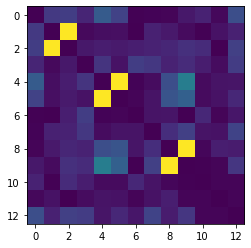

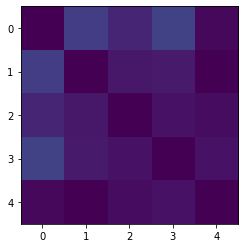

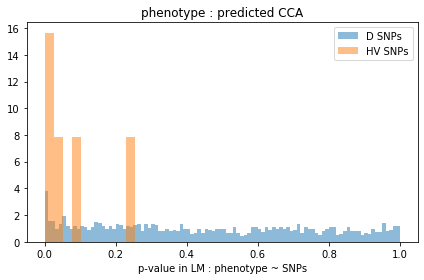

In [84]:
all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    
    plot_correlations(X_G_H,significant_SNPs[pheno])
    
    to_remove = []
    
    for i in range(len(significant_SNPs[pheno])):
        for j in range(i+1,len(significant_SNPs[pheno])):
            s1 = significant_SNPs[pheno][i]
            s2 = significant_SNPs[pheno][j]
            if s2 in to_remove: continue
            if s1 in to_remove: continue
            if pearsonr(X_G_H[s1],X_G_H[s2])[0]**2 > 1e-4:
                to_remove.append(s2)
    
    uncorr_significant_snps = [s for s in significant_SNPs[pheno] if s not in to_remove]
    
    plot_correlations(X_G_H,uncorr_significant_snps)
    
    all_hits = list(set(all_d_hits + uncorr_significant_snps))
    #all_hits = significant_SNPs[pheno]
    lm = LinearRegression().fit(X_G_H[all_hits],adj_cov)
    pred = lm.predict(X_G_H[all_hits])
    
    lm_info = get_lm_info(X_G_H[all_hits],adj_cov,pred,lm)
    lm_info["P_alone"] = [pearsonr(X_G_H[s],adj_cov)[1] for s in all_hits]
    lm_info["SNP"] = all_hits
    lm_info.set_index("SNP",inplace=True)
    
    plt.figure()
    plt.hist(lm_info["P"],density=True,bins=100,alpha=.5,label="D SNPs")
    plt.hist(lm_info.loc[uncorr_significant_snps,"P"],density=True,alpha=.5,label="HV SNPs")
    plt.xlabel("p-value in LM : phenotype ~ SNPs")
    plt.title("phenotype : predicted %s" % pheno)
    plt.legend()
    plt.tight_layout()

In [85]:
illustrate = pd.merge(gw.loc[gw.pheno == pheno],lm_info,left_on="SNP",right_index=True,how="inner")

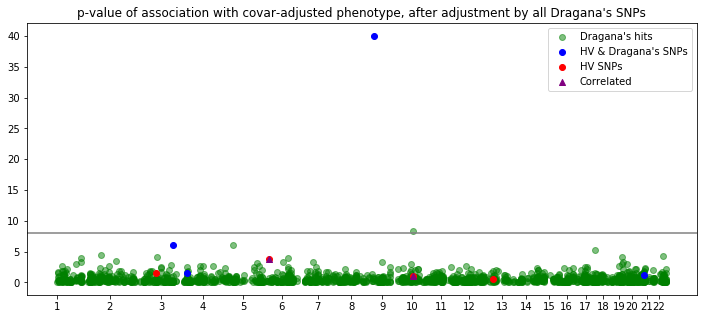

In [86]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
is_corr = illustrate.SNP.isin([significant_SNPs[pheno][i] for i in corr_snps])
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_y"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_y"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_y"]),c="red",alpha=1,label="HV SNPs")
plt.scatter(illustrate.loc[is_HV & is_corr,"POS"],-np.log10(illustrate.loc[is_HV & is_corr,"P_y"]),c="purple",marker="^",alpha=1,label="Correlated")
plt.axhline(8,c="grey")
plt.title("p-value of association with covar-adjusted phenotype, after adjustment by all Dragana's SNPs")
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

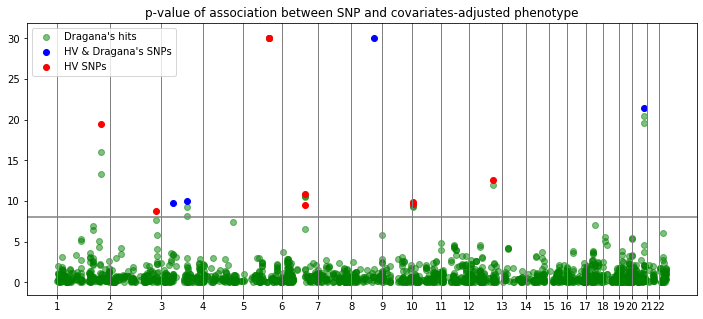

In [32]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],       np.clip(-np.log10(illustrate.loc[~is_HV,"P_alone"]),0,30),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"], np.clip(-np.log10(illustrate.loc[is_HV & is_D,"P_alone"]),0,30),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],np.clip(-np.log10(illustrate.loc[is_HV & ~is_D,"P_alone"]),0,30),c="red",alpha=1,label="HV SNPs")

plt.axhline(8,c="grey")
plt.title("p-value of association between SNP and covariates-adjusted phenotype")
for c in [gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)]:
    plt.axvline(c,color="grey",lw=1)
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

# Look in Dragana's GWAS

In [33]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["SNP"].isin(all_significant_SNPs)]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [34]:
sysmex_pheno = ~dgw.pivot_table(aggfunc="first",index="SNP",columns="Associated Blood Index",values=["Gene"])["Gene"].isnull()

In [35]:
genes = dgw.groupby("SNP")[["Gene"]].first()
genes

,Gene
SNP,
rs11916134,UMPS
rs1354034,ARHGEF3
rs415064,TUBB1
rs6993770,ZFPM2


In [36]:
sysmex_pheno["Dragana GWAS traits"] = ""
for c in sysmex_pheno.columns:
    if c == "Dragana GWAS traits": continue
    sysmex_pheno.loc[sysmex_pheno[c],"Dragana GWAS traits"] += "%s " % c

In [37]:
recap = pd.merge(recap,sysmex_pheno[["Dragana GWAS traits"]],how="left",left_index=True,right_index=True).fillna("")

In [38]:
import myvariant
mv = myvariant.MyVariantInfo()

gene_names = {}
to_query = recap.index.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"][0]["genename"]
                    except:
                        if q == "rs111763415":
                            gene = "SUFU"
                        else:
                            gene = "not found"
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

for q in gene_names:
    recap.loc[q,"genes"] = ", ".join(list(set(gene_names[q])))

querying 1-13...done.
Finished.
7 input query terms found dup hits:
	[('rs2057150', 2), ('rs597808', 3), ('rs415064', 2), ('rs17020993', 2), ('rs9372251', 2), ('rs112516
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [39]:
# for gene ontology
for gene in recap.genes.unique().tolist():
    print(gene.split("-")[0])

ZFPM2
ATG9A
DDO
ARHGEF3
ATXN2
LOC101927379
SNX24
TUBB1
C4BPA
METTL24
LOC101927824
UMPS
PFKP


In [40]:
recap.sort_values(["CHR","BP"])

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs17020993,True,0.125358,4.300000e-19,0.879310,1,207288392,,C4BPA
rs72955435,True,0.098276,7.100000e-10,0.911575,2,220087354,,ATG9A
rs1354034,True,-0.058354,6.300000e-10,0.404338,3,56849749,HLSR# HLSR% LYMPH# LYMPH% MPV PCT PLT# RET# RET%,ARHGEF3
rs11916134,True,0.062459,1.300000e-09,0.730533,3,124453114,PCT,UMPS
rs6595407,True,-0.120646,6.400000e-40,0.443586,5,122100398,,LOC101927379-SNX2
rs425573,True,0.123047,4.400000e-37,0.670216,5,122326008,,SNX24
rs9372251,True,-0.061588,5.500000e-11,0.561868,6,110700656,,METTL24-DDO
rs2057150,True,-0.066250,2.300000e-09,0.732599,6,110716722,,DDO
rs6993770,True,0.120753,1.300000e-33,0.713156,8,106581528,MPV PCT PDW PLT#,ZFPM2
rs11251684,True,-0.070441,3.900000e-09,0.176845,10,3102379,,LOC101927824


In [35]:
recap.to_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag)

# Manhattan plot

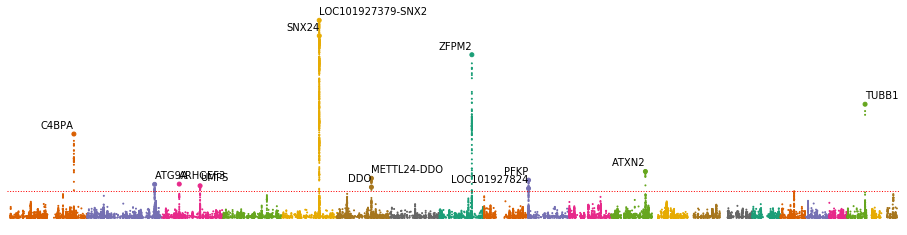

In [41]:
cmap = plt.get_cmap("Dark2")
for c in pheno_cols:
    g = gw_.loc[gw_.pheno == c]
    g.P = np.clip(g.P,a_min=1e-40,a_max=1)
    plt.figure(figsize=(16,4))
    plt.scatter(g.POS,-np.log10(g.P),c=cmap(g.CHR % 8),s=1 + 15*g.SNP.isin(significant_SNPs[c]))
    plt.xticks([g.loc[g.CHR == ch,"POS"].min() for ch in range(1,23)],[str(ch) for ch in range(1,23)])
    plt.axhline(8,c="red",ls=":",lw=1)
    written_genes = []
    for i, snp in enumerate(recap.loc[recap["causal_%s" % c]].index):
        pos = g.loc[g.SNP == snp,"POS"] #+ (i % 2)*1e7 - 5e6
        height = 1 - np.log10(g.loc[g.SNP == snp,"P"])
        gene = recap.loc[snp,"genes"]
        if gene not in written_genes:
            plt.text(pos, height,gene,ha="right" if i % 2 == 0 else "left")
            written_genes.append(gene)
    plt.axis("off")
    plt.xlim((g.POS.min()-1e7,g.POS.max() + 1e7))

# Compute score

In [42]:
raise "Error"

TypeError: exceptions must derive from BaseException

In [43]:
causal_snps = {}
for c in pheno_cols:
    causal_path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    causal_snps[c] = [c[:-1] for c in open(causal_path,"r").readlines()]

In [44]:
good = {}
for c in pheno_cols:
    good[c] = gw.loc[(gw.pheno == c) & (gw.SNP.isin(causal_snps[c]))]

In [45]:
pheno_cols

['CCA']

In [46]:
first_pheno = pheno_cols[0]
betas = good[first_pheno][["SNP","BETA"]].rename(columns={"BETA":first_pheno})
for c in pheno_cols[1:]:
    betas = pd.merge(betas,good[c][["SNP","BETA"]].rename(columns={"BETA":c}),
                     left_on="SNP",right_on="SNP",how="outer")
betas = pd.merge(betas,gw.loc[gw.pheno == first_pheno,["SNP","ALLELE1"]],left_on="SNP",right_on="SNP",how="left")
betas = betas[["SNP","ALLELE1"] + pheno_cols]
betas.fillna(0,inplace=True)
assert betas.shape[0] == betas.SNP.nunique()

In [44]:
good_chroms = []
for c in good:
    good_chroms += good[c].CHR.unique().tolist()
good_chroms = list(set(good_chroms))
print(good_chroms)

[1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22]


In [45]:
betas.head()

,SNP,ALLELE1,CCA
0,rs1764405,A,0.074991
1,rs12041331,G,-0.133169
2,rs2180747,G,0.071455
3,rs10914144,T,0.087074
4,rs1124025,C,-0.063734


In [46]:
if not os.path.exists("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag)):
    os.mkdir("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag))

In [47]:
betas_path = "%s/Genetic_score_Sysmex_traits/betas.csv" % (export_folder)
betas.to_csv(betas_path,
            sep="\t",index=False)

n_splits = 16

all_causal_path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)

for chrom in good_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    #command += " --extract %s" % causal_snps_path
    command += " --keep %s" % EUR_path
    command += " --extract %s" % all_causal_path
    command += " --score %s header-read" % betas_path
    if len(pheno_cols) > 1:
        command += " --score-col-nums 3-%d" % (2 + len(pheno_cols))
    else:
        command += " --score-col-nums 3"
    command += " --out %s/Genetic_score_Sysmex_traits/%s/good_score_chr%s" % (export_folder,tag,chrom)
    command += " --threads %d" % n_splits

    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=8:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 16
Submitting 17
Submitting 19
Submitting 20
Submitting 22


# Read PLINK GWAS